<a href="https://colab.research.google.com/github/marcomoretto/VESPUCCI/blob/master/VESPUCCI_with_pyCOMPASS_use_case_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VESPUCCI use case n° 5

[VESPUCCI](https://vespucci.readthedocs.io/) is the gene expression database for grapevine and we can access it via its GraphQL interface, called [COMPASS](https://compass-.readthedocs.io/). The [pyCOMPASS](https://pycompass.readthedocs.io/) package is a Python package that wraps some functionalities to simplify communication with the [COMPASS](https://compass-.readthedocs.io/) interface.

In this use case the main aim is to identify tissue-specific expressions of two sets of target genes regulated by the stilbene-related MYB14 transcription factor. Specific objetives are to compare different sets of targets based in the position of their MYB14-binding. Target genes were filtered as i) promoter-bound (up to -3kb from each transcription start site; 1188 peaks corresponding to 1022 genes) and ii) gene body + 3' downstream-bound (up to 2kb from the end of each gene feature; 1734 peaks corresponding to 1489 genes). 



In [ ]:
!pip install pycompass==0.8.3

In [ ]:
!pip install goatools
!pip install fisher
!pip install statsmodels
!pip install pydot

     |████████████████████████████████| 15.1 MB 96 kB/s 
     |████████████████████████████████| 148 kB 78.7 MB/s 
     |████████████████████████████████| 103 kB 74.4 MB/s 
  Created wheel for goatools: filename=goatools-1.1.6-py3-none-any.whl size=15762836 sha256=f7da3331dc46df1aec2b02b94613dce0be764c5f4a664d46ab69f12e5722dd2a
  Stored in directory: /root/.cache/pip/wheels/ed/a7/4b/2e9ce970761985d8c6c6caab01fd0fa79fbc576942e11ad5e4
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=70c399767224a88fc12b09ca8bfaa0a08af960282c08979c346ed14b3c6339f0
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built goatools wget
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0
     |████████████████████████████████| 145 kB 15.4 MB/s 
  Created wheel for fisher: filename=fisher-0.1.9-cp37-cp37m-linux_x86_64.whl 

In [ ]:
!pip install SPARQLWrapper

     |████████████████████████████████| 379 kB 17.3 MB/s 
     |████████████████████████████████| 45 kB 2.2 MB/s 


### Import the pyCOMPASS module and classes

In [ ]:
from pycompass import Compendium, Connect, BiologicalFeature, Module, SampleSet, Plot, Annotation, Experiment, Sample, Platform, Ontology, OntologyNode, Sparql
from IPython.core.display import HTML
import numpy as np
import gdown
import pandas as pd
from scipy import stats
import plotly.figure_factory as ff
import plotly.graph_objects as go
from statsmodels.sandbox.stats.multicomp import multipletests
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj
from IPython.display import Image
import requests
from SPARQLWrapper import SPARQLWrapper, JSON

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### The Connect object represent our connection to the COMPASS GraphQL endpoint

In [ ]:
connect = Connect('http://compass.fmach.it/graphql')

We will be using the TPM normalization compendium in order to retrieve genes that are most likely highly expressed

In [ ]:
compendium_tpm = connect.get_compendium('vespucci', normalization='tpm')

### Gene list

In [ ]:
url = 'https://drive.google.com/uc?id=1NWMF3E9AmBpV8xbzaYFLUyr33dhmMFfd'
output3 = 'myb14-3kb.csv'
gdown.download(url, output3, quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1NWMF3E9AmBpV8xbzaYFLUyr33dhmMFfd
To: /content/myb14-3kb.csv
100%|██████████| 22.5k/22.5k [00:00<00:00, 5.97MB/s]


'myb14-3kb.csv'

In [ ]:
url = 'https://drive.google.com/uc?id=1U97m4KVMLcnlOJcRmtJE3-ha_rv6W2x_'
output2 = 'myb14+2kb.csv'
gdown.download(url, output2, quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1U97m4KVMLcnlOJcRmtJE3-ha_rv6W2x_
To: /content/myb14+2kb.csv
100%|██████████| 32.9k/32.9k [00:00<00:00, 9.44MB/s]


'myb14+2kb.csv'

In [ ]:
df_myb143kb = pd.read_csv(output3, sep='\t')
gene_list_3kb = list(set([gid for gid in df_myb143kb['feature'].to_list() if gid.startswith('VIT_')]))

In [ ]:
df_myb142kb = pd.read_csv(output2, sep='\t')
gene_list_2kb = list(set([gid for gid in df_myb142kb['feature'].to_list() if gid.startswith('VIT_')]))

Detail on the overlapping genes


In [ ]:
overlapping_genes = set(gene_list_3kb).intersection(set(gene_list_2kb))

In [ ]:
gene_list_3kb = list(set(gene_list_3kb) - overlapping_genes)
gene_list_2kb = list(set(gene_list_2kb) - overlapping_genes)

In [ ]:
bf_3kb = BiologicalFeature.using(compendium_tpm).get(filter={'name_In': gene_list_3kb})
bf_2kb = BiologicalFeature.using(compendium_tpm).get(filter={'name_In': gene_list_2kb})

Samples are collected using specific Plant ontology terms used to annotate the different tissues. Together with basic terms (like fruit) also more specific terms are used (such as berry fruit).

In [ ]:
root = OntologyNode.using(compendium_tpm).get(filter={"originalId": "PO_0009005", "ontology_Name": "Plant ontology"})
stem = OntologyNode.using(compendium_tpm).get(filter={"originalId": "PO_0009047", "ontology_Name": "Plant ontology"})
leaf = OntologyNode.using(compendium_tpm).get(filter={"originalId": "PO_0025034", "ontology_Name": "Plant ontology"})
flower = OntologyNode.using(compendium_tpm).get(filter={"originalId": "PO_0009046", "ontology_Name": "Plant ontology"})
fruit = OntologyNode.using(compendium_tpm).get(filter={"originalId": "PO_0009001", "ontology_Name": "Plant ontology"})

root_terms = OntologyNode.using(compendium_tpm).get(filter={"descendantOf": root[0].id}) + root
stem_terms = OntologyNode.using(compendium_tpm).get(filter={"descendantOf": stem[0].id}) + stem
leaf_terms = OntologyNode.using(compendium_tpm).get(filter={"descendantOf": leaf[0].id}) + leaf
flower_terms = OntologyNode.using(compendium_tpm).get(filter={"descendantOf": flower[0].id}) + flower
fruit_terms = OntologyNode.using(compendium_tpm).get(filter={"descendantOf": fruit[0].id}) + fruit

Now that we have all the terms for the 5 tissues we can build the SPARQL queries to obtain only those samples we are interested in. We will filter out all samples with Inoculation and Treatment terms (`NCIT_C68774`, `AGRO_00000322`).

In [ ]:
tissue_samples = {}
for tissue_terms, tissue in [(root_terms, 'root'), (stem_terms, 'stem'), (leaf_terms, 'leaf'), (flower_terms, 'flower'), (fruit_terms, 'fruit')]:
  sparql = "SELECT ?s ?p ?o " + \
    "WHERE {{ ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://purl.obolibrary.org/obo/NCIT_C19157> . " + \
             " {terms_sparql}  {filter} }}"
  terms_sparql = []
  for term in tissue_terms:
    terms_sparql.append("{{?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://purl.obolibrary.org/obo/{t}>}}".format(t=term.originalId))
  sparql = sparql.format(terms_sparql=' UNION '.join(terms_sparql),
              filter="FILTER NOT EXISTS { VALUES ?p1 { <http://purl.obolibrary.org/obo/NCIT_C68774> <http://purl.obolibrary.org/obo/AGRO_00000322> } " + \
                      " ?s ?p1 ?o1 } ")
  tissue_samples[tissue] = Sample.using(compendium_tpm).by(sparql=sparql)

Since getting all TPM data for thousand of samples and genes might take a while, we prepared an HDF5 file with all the data we will need. In order to see how to create such file just execute the last cells of the notebook.

In [ ]:
url = 'https://drive.google.com/uc?id=1__hzpE0eLFiA6jS-2paJy4Dhlm6fvXN5'
output = 'vespucci_tpm.hdf'
gdown.download(url, output, quiet=False) 
module_tpm = pd.read_hdf(output, "table")

Downloading...
From: https://drive.google.com/uc?id=1__hzpE0eLFiA6jS-2paJy4Dhlm6fvXN5
To: /content/vespucci_tpm.hdf
850MB [00:07, 117MB/s]


With the TPM values we will create a DataFrame by ranking all genes within each sample.

In [ ]:
module_rank = module_tpm.rank(method='max', ascending=True, na_option='top')
module_rank[module_tpm.isna()] = np.NaN

In [ ]:
module_rank.head()

,GSM1551306.ch1,GSM1551303.ch1,GSM1551304.ch1,GSM1551305.ch1,GSM1551302.ch1,GSM1551307.ch1,GSM926672.ch1,GSM926671.ch1,GSM926668.ch1,GSM926670.ch1,GSM926673.ch1,GSM926667.ch1,GSM926669.ch1,GSM1423070.ch1,GSM1423078.ch1,GSM1423075.ch1,GSM1423071.ch1,GSM1423076.ch1,GSM1423073.ch1,GSM1423072.ch1,GSM1423079.ch1,GSM1423077.ch1,GSM1423074.ch1,GSM1423080.ch1,GSM1423069.ch1,GSM1400261.ch1,GSM1400260.ch1,GSM1400259.ch1,GSM1400257.ch1,GSM1400258.ch1,GSM1400256.ch1,SRX374878,SRX374872,SRX374888,SRX374889,SRX374877,SRX374876,SRX374875,SRX374874,SRX374882,...,SRR1026383,SRR1026388,SRR1026406,SRR1026409,SRR1026429,SRR1026435,SRR1026453,SRR1026459,SRR1026471,SRR1026489,SRR1026495,SRR1026513,SRR1026519,SRR1026537,SRR1026543,SRR1026561,SRR1026567,SRR1026585,SRR1026591,SRR1026597,SRR1026621,SRR1026627,SRR1026645,SRR1026651,SRR1026669,SRR1026675,SRR1026693,SRR1026700,SRR1026717,SRR1026723,SRR1026735,SRR1026753,SRR1026759,SRR1026777,SRR1026795,SRR1026801,SRR1026820,SRR1026825,SRR1558172,SRR1557134
VIT_10s0116g00040,10120.0,9297.0,10691.0,NaN,NaN,10889.0,14318.0,16018.0,12816.0,15497.0,13780.0,10818.0,12397.0,13010.0,10455.0,10376.0,12227.0,11869.0,9021.0,10416.0,10850.0,11743.0,9456.0,NaN,10428.0,14078.0,8677.0,9886.0,8906.0,13423.0,10550.0,10143.0,5013.0,12780.0,11125.0,9725.0,10516.0,6121.0,8731.0,8726.0,...,5713.0,9549.0,6124.0,5241.0,6946.0,7184.0,8594.0,6266.0,6536.0,8288.0,11755.0,7121.0,7405.0,7475.0,6703.0,7191.0,6984.0,7513.0,6912.0,6444.0,7804.0,13031.0,7833.0,7425.0,8303.0,8044.0,7412.0,7115.0,11662.0,6567.0,6375.0,7681.0,7672.0,6056.0,6950.0,6146.0,6838.0,6772.0,9419.0,7923.0
VIT_10s0116g00060,16936.0,17694.0,18373.0,17000.0,15759.0,16388.0,16648.0,16694.0,17708.0,19043.0,15865.0,22464.0,16370.0,8955.0,9480.0,9211.0,9792.0,9215.0,9646.0,10653.0,8661.0,8152.0,9550.0,11227.0,10084.0,20418.0,13387.0,13333.0,14045.0,16321.0,13782.0,16396.0,13005.0,15567.0,16316.0,17367.0,15331.0,12719.0,14373.0,16856.0,...,14876.0,16860.0,12499.0,12938.0,25778.0,25947.0,27260.0,25118.0,16949.0,27705.0,27529.0,27566.0,25705.0,25436.0,25065.0,26649.0,26470.0,25835.0,24557.0,13079.0,24586.0,25071.0,23905.0,26356.0,24527.0,26307.0,25268.0,26071.0,24863.0,22626.0,16330.0,25851.0,23929.0,15352.0,12743.0,18045.0,14989.0,12139.0,20905.0,19854.0
VIT_10s0116g00070,11476.0,14560.0,12379.0,8949.0,9089.0,11580.0,15349.0,16262.0,14070.0,15838.0,14671.0,17491.0,12866.0,13618.0,13348.0,14312.0,12604.0,14944.0,12479.0,13002.0,13306.0,14666.0,13124.0,13393.0,12566.0,19914.0,14478.0,13741.0,14573.0,18875.0,14485.0,9163.0,9251.0,9594.0,9140.0,10797.0,10785.0,11823.0,10262.0,10793.0,...,11212.0,11222.0,10922.0,10476.0,12868.0,12839.0,13007.0,11093.0,10471.0,10939.0,13400.0,13335.0,11931.0,12988.0,11512.0,13145.0,12881.0,12499.0,11368.0,9639.0,13445.0,13601.0,13408.0,10828.0,12839.0,11957.0,10797.0,12679.0,12485.0,11566.0,9834.0,12381.0,12621.0,11667.0,11086.0,11334.0,11779.0,10454.0,18449.0,19024.0
VIT_10s0116g00080,6511.0,NaN,NaN,11463.0,11105.0,NaN,NaN,5177.0,7478.0,NaN,5724.0,5276.0,8511.0,8784.0,6458.0,8441.0,10764.0,7818.0,8404.0,8446.0,7536.0,6877.0,8404.0,7639.0,10596.0,7493.0,14333.0,14283.0,15708.0,6162.0,14644.0,1334.0,1880.0,6080.0,5917.0,2981.0,1991.0,4239.0,3559.0,2453.0,...,10335.0,10119.0,10277.0,9622.0,6946.0,7184.0,8751.0,6266.0,11272.0,8288.0,8057.0,7247.0,7405.0,7475.0,6703.0,7191.0,6984.0,7513.0,6912.0,10960.0,7804.0,8122.0,7833.0,7425.0,8303.0,8044.0,7412.0,7115.0,6804.0,6567.0,10684.0,7681.0,7672.0,10631.0,11473.0,12492.0,9455.0,9609.0,9897.0,11773.0
VIT_10s0116g00150,NaN,5566.0,6819.0,NaN,NaN,6906.0,19579.0,21475.0,18343.0,23600.0,19768.0,14296.0,17601.0,14162.0,13238.0,11949.0,11105.0,11575.0,10819.0,10589.0,16417.0,16068.0,14139.0,13968.0,11580.0,6825.0,4558.0,5794.0,5276.0,9792.0,5500.0,5141.0,2485.0,4130.0,3958.0,3920.0,6253.0,3877.0,3604.0,5851.0,...,7613.0,8604.0,10907.0,7643.0,23039.0,23035.0,22626.0,23756.0,7727.0,23365.0,25249.0,21897.0,21369.0,25580.0,25491.0,22370.0,23850.0,23949.0,21271.0,7443.0,26845.0,27538.0,23633.0,26330.0,27481.0,26522.

Given a gene we are now able to empirically calculate 95% confidence intervals of rank mean by random resampling from all ranks of the gene across all conditions and check whether or not our specific sample of ranks (coming from just flower tissue for example) is outside that interval.
For the Central Limit Theorem the distribution of ranked means is normally distributed, thus we can fit a Gaussian distribution and obtain a p-value associated with the rank mean for each tissue.

In [ ]:
gene_name = gene_list_3kb[100]
tissues = [s.sampleName for s in tissue_samples['flower']]
gene_ranks = module_rank.loc[gene_name].values
size = len(tissues)
gene_ranks_samples = np.asarray([
      np.random.choice(
          gene_ranks, size=size, replace=False
    ) for _ in range(10000)
])
mean_dist = np.nanmean(gene_ranks_samples, axis=1)
mean_sample = module_rank.loc[gene_name][tissues].mean()
mu, sigma = stats.norm.fit(mean_dist)
x = np.linspace(np.min(mean_dist), np.max(mean_dist), 1000)
y = stats.norm.pdf(x, mu, sigma)

print('Sample size', size)
print('Flower samples rank mean', mean_sample)
print('Confidence interval:', np.percentile(mean_dist, [2.5,97.5]))
print('P-value:', stats.norm.sf(mean_sample, loc=mu, scale=sigma))

fig = ff.create_distplot([mean_dist], ['Distribution of rank means'], bin_size=100)
fig.add_trace(
    go.Scatter(x=x, y=y, name='Fitted Gaussian distribution')
)
fig.show()

Sample size 36
Flower samples rank mean 17268.222222222223
Confidence interval: [17721.21944444 19154.78904762]
P-value: 0.9993289923737606


In [ ]:
module_rank.head()

,GSM1551306.ch1,GSM1551303.ch1,GSM1551304.ch1,GSM1551305.ch1,GSM1551302.ch1,GSM1551307.ch1,GSM926672.ch1,GSM926671.ch1,GSM926668.ch1,GSM926670.ch1,GSM926673.ch1,GSM926667.ch1,GSM926669.ch1,GSM1423070.ch1,GSM1423078.ch1,GSM1423075.ch1,GSM1423071.ch1,GSM1423076.ch1,GSM1423073.ch1,GSM1423072.ch1,GSM1423079.ch1,GSM1423077.ch1,GSM1423074.ch1,GSM1423080.ch1,GSM1423069.ch1,GSM1400261.ch1,GSM1400260.ch1,GSM1400259.ch1,GSM1400257.ch1,GSM1400258.ch1,GSM1400256.ch1,SRX374878,SRX374872,SRX374888,SRX374889,SRX374877,SRX374876,SRX374875,SRX374874,SRX374882,...,SRR1026383,SRR1026388,SRR1026406,SRR1026409,SRR1026429,SRR1026435,SRR1026453,SRR1026459,SRR1026471,SRR1026489,SRR1026495,SRR1026513,SRR1026519,SRR1026537,SRR1026543,SRR1026561,SRR1026567,SRR1026585,SRR1026591,SRR1026597,SRR1026621,SRR1026627,SRR1026645,SRR1026651,SRR1026669,SRR1026675,SRR1026693,SRR1026700,SRR1026717,SRR1026723,SRR1026735,SRR1026753,SRR1026759,SRR1026777,SRR1026795,SRR1026801,SRR1026820,SRR1026825,SRR1558172,SRR1557134
VIT_10s0116g00040,10120.0,9297.0,10691.0,NaN,NaN,10889.0,14318.0,16018.0,12816.0,15497.0,13780.0,10818.0,12397.0,13010.0,10455.0,10376.0,12227.0,11869.0,9021.0,10416.0,10850.0,11743.0,9456.0,NaN,10428.0,14078.0,8677.0,9886.0,8906.0,13423.0,10550.0,10143.0,5013.0,12780.0,11125.0,9725.0,10516.0,6121.0,8731.0,8726.0,...,5713.0,9549.0,6124.0,5241.0,6946.0,7184.0,8594.0,6266.0,6536.0,8288.0,11755.0,7121.0,7405.0,7475.0,6703.0,7191.0,6984.0,7513.0,6912.0,6444.0,7804.0,13031.0,7833.0,7425.0,8303.0,8044.0,7412.0,7115.0,11662.0,6567.0,6375.0,7681.0,7672.0,6056.0,6950.0,6146.0,6838.0,6772.0,9419.0,7923.0
VIT_10s0116g00060,16936.0,17694.0,18373.0,17000.0,15759.0,16388.0,16648.0,16694.0,17708.0,19043.0,15865.0,22464.0,16370.0,8955.0,9480.0,9211.0,9792.0,9215.0,9646.0,10653.0,8661.0,8152.0,9550.0,11227.0,10084.0,20418.0,13387.0,13333.0,14045.0,16321.0,13782.0,16396.0,13005.0,15567.0,16316.0,17367.0,15331.0,12719.0,14373.0,16856.0,...,14876.0,16860.0,12499.0,12938.0,25778.0,25947.0,27260.0,25118.0,16949.0,27705.0,27529.0,27566.0,25705.0,25436.0,25065.0,26649.0,26470.0,25835.0,24557.0,13079.0,24586.0,25071.0,23905.0,26356.0,24527.0,26307.0,25268.0,26071.0,24863.0,22626.0,16330.0,25851.0,23929.0,15352.0,12743.0,18045.0,14989.0,12139.0,20905.0,19854.0
VIT_10s0116g00070,11476.0,14560.0,12379.0,8949.0,9089.0,11580.0,15349.0,16262.0,14070.0,15838.0,14671.0,17491.0,12866.0,13618.0,13348.0,14312.0,12604.0,14944.0,12479.0,13002.0,13306.0,14666.0,13124.0,13393.0,12566.0,19914.0,14478.0,13741.0,14573.0,18875.0,14485.0,9163.0,9251.0,9594.0,9140.0,10797.0,10785.0,11823.0,10262.0,10793.0,...,11212.0,11222.0,10922.0,10476.0,12868.0,12839.0,13007.0,11093.0,10471.0,10939.0,13400.0,13335.0,11931.0,12988.0,11512.0,13145.0,12881.0,12499.0,11368.0,9639.0,13445.0,13601.0,13408.0,10828.0,12839.0,11957.0,10797.0,12679.0,12485.0,11566.0,9834.0,12381.0,12621.0,11667.0,11086.0,11334.0,11779.0,10454.0,18449.0,19024.0
VIT_10s0116g00080,6511.0,NaN,NaN,11463.0,11105.0,NaN,NaN,5177.0,7478.0,NaN,5724.0,5276.0,8511.0,8784.0,6458.0,8441.0,10764.0,7818.0,8404.0,8446.0,7536.0,6877.0,8404.0,7639.0,10596.0,7493.0,14333.0,14283.0,15708.0,6162.0,14644.0,1334.0,1880.0,6080.0,5917.0,2981.0,1991.0,4239.0,3559.0,2453.0,...,10335.0,10119.0,10277.0,9622.0,6946.0,7184.0,8751.0,6266.0,11272.0,8288.0,8057.0,7247.0,7405.0,7475.0,6703.0,7191.0,6984.0,7513.0,6912.0,10960.0,7804.0,8122.0,7833.0,7425.0,8303.0,8044.0,7412.0,7115.0,6804.0,6567.0,10684.0,7681.0,7672.0,10631.0,11473.0,12492.0,9455.0,9609.0,9897.0,11773.0
VIT_10s0116g00150,NaN,5566.0,6819.0,NaN,NaN,6906.0,19579.0,21475.0,18343.0,23600.0,19768.0,14296.0,17601.0,14162.0,13238.0,11949.0,11105.0,11575.0,10819.0,10589.0,16417.0,16068.0,14139.0,13968.0,11580.0,6825.0,4558.0,5794.0,5276.0,9792.0,5500.0,5141.0,2485.0,4130.0,3958.0,3920.0,6253.0,3877.0,3604.0,5851.0,...,7613.0,8604.0,10907.0,7643.0,23039.0,23035.0,22626.0,23756.0,7727.0,23365.0,25249.0,21897.0,21369.0,25580.0,25491.0,22370.0,23850.0,23949.0,21271.0,7443.0,26845.0,27538.0,23633.0,26330.0,27481.0,26522.

We could now calculate the p-values for all of our initial list of genes on all tissue and check whether the p-value suggest that a specific gene for a specific tissue is likely to be highly expressed. The calculation is done for thousands of genes so it might take a while to calculate from scratch. We have already pre-calculated all the p-values and putted them in a CSV file. The procedure to obtain the p-values is reported at the end of the notebook.

In [ ]:
url = 'https://drive.google.com/uc?id=1Yz2fV3hT1ICWD9jsoo0xLn5wyJjc03eN'
output = 'p_values.csv'
gdown.download(url, output, quiet=False) 
p_values = pd.read_csv(output, sep='\t', index_col=0).T

Downloading...
From: https://drive.google.com/uc?id=1Yz2fV3hT1ICWD9jsoo0xLn5wyJjc03eN
To: /content/p_values.csv
100%|██████████| 336k/336k [00:00<00:00, 56.5MB/s]


In [ ]:
p_values.head()

,fruit,flower,root,leaf,stem
VIT_01s0011g02580,5.530788e-01,0.662269,0.440889,7.185824e-01,1.260904e-01
VIT_11s0016g00160,1.104935e-88,0.908668,1.000000,1.000000e+00,9.969023e-01
VIT_05s0124g00520,2.410358e-11,0.898739,0.999992,1.000000e+00,9.973455e-01
VIT_15s0048g01600,1.000000e+00,0.997329,1.000000,3.903212e-32,9.955366e-01
VIT_11s0149g00120,6.877126e-16,0.999998,1.000000,1.000000e+00,1.360999e-20


P-values get adjusted with Bonferroni correction and divided in two lists **TODO**

In [ ]:
tissue_high_exp_genes = {}
for tissue in ['root', 'stem', 'leaf', 'flower', 'fruit']:
  p_adjusted = multipletests(p_values[tissue], alpha=0.001, method='bonferroni')
  highly_expressed_genes = p_values[tissue][p_adjusted[0]].index.to_list()
  highly_expressed_genes_3kb = [x for x in highly_expressed_genes if x in gene_list_3kb]
  highly_expressed_genes_2kb = [x for x in highly_expressed_genes if x in gene_list_2kb]
  tissue_high_exp_genes[tissue] = (('3kb', highly_expressed_genes_3kb), ('2kb', highly_expressed_genes_2kb))

In [ ]:
tissue_unique_high_exp_genes = {}
tissues = ['root', 'stem', 'leaf', 'flower', 'fruit']
for tissue in tissues:
  tissue_unique_high_exp_genes[tissue] = {}
  for pos in [0, 1]:
    t = set(tissue_high_exp_genes[tissue][pos][1])
    o = set([_g for _t in set(tissues) - set([tissue]) for _g in tissue_high_exp_genes[_t][pos][1]])
    tissue_unique_high_exp_genes[tissue][pos] = t - o

### Retrieve the GO annotation
Now it's time to retrieve all the GO terms for our genes and see if in the subsets of genes there are GO terms that are over-represented compared to the full annotation.

We might want to use the Annotation class to retrieve the annotation for all our genes filtering out the GO terms, but to avoid the overhead given by the large number of genes to use, it is better to perform a lower level operation and go directly with a SPARQL query for the annotation terms we are interested in. 

In [ ]:
sparql = "SELECT ?s ?o WHERE {?s <http://purl.obolibrary.org/obo/NCIT_C44272> ?o FILTER (strstarts(str(?o), 'GO_'))}"
triples = Sparql.using(compendium_tpm).execute_query(sparql, 'biofeature')

Let's select all genes from the compendium

In [ ]:
genes = BiologicalFeature.using(compendium_tpm).get()

And populate a dictionary with all the GO annotation

In [ ]:
go_assoc = {'ALL': {}}
gene_ids = {g.id:g.name for g in genes}
for t in triples:
  gid = gene_ids[t[0]]
  if gid not in go_assoc['ALL']:
    go_assoc['ALL'][gid] = set()
  go_assoc['ALL'][gid].add(t[1].replace('_', ':'))

## Setup the GO analysis
VESPUCCI provides a basic enrichment tool, but to perform a more complete analysis we will rely on an external package such as `goatools`.
To start the GO analysis we will download the basic GO and create both DAGs objects.

In [ ]:
obo_fname = download_go_basic_obo()
obodag = GODag("go-basic.obo")

requests.get(http://purl.obolibrary.org/obo/go/go-basic.obo, stream=True)
  WROTE: go-basic.obo

go-basic.obo: fmt(1.2) rel(2021-07-02) 47,229 GO Terms


### Perform the enrichment analysis using our subset of genes and display the GO graph result

In [ ]:
study = GOEnrichmentStudyNS(
        go_assoc['ALL'].keys(),
        go_assoc,
        obodag,
        propagate_counts = False,
        alpha = 0.05,
        methods = ['fdr_bh'])


Load ALL Gene Ontology Analysis ...
100% 15,136 of 15,136 population items found in association


In [ ]:
for tissue, pos_list in tissue_high_exp_genes.items():
  for name, pos in pos_list:
    goea_results_all = study.run_study(pos, prt=None)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    filename = "{tissue}_highly_expressed_genes_{pos}".format(tissue=tissue, pos=name)
    plot_results(filename + "_{NS}.png", goea_results_sig)

    1 usr  19 GOs  WROTE: stem_highly_expressed_genes_2kb_BP.png
    4 usr  42 GOs  WROTE: fruit_highly_expressed_genes_3kb_BP.png
    1 usr  15 GOs  WROTE: fruit_highly_expressed_genes_2kb_BP.png


In [ ]:
for tissue, pos_list in tissue_unique_high_exp_genes.items():
  for name, pos in pos_list.items():
    goea_results_all = study.run_study(pos, prt=None)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    filename = "{tissue}_unique_highly_expressed_genes_{pos}".format(tissue=tissue, pos=name)
    plot_results(filename + "_{NS}.png", goea_results_sig)

    1 usr  15 GOs  WROTE: fruit_unique_highly_expressed_genes_1_BP.png


### GO enrichment for uniquely highly expressed genes in fruit TODO**

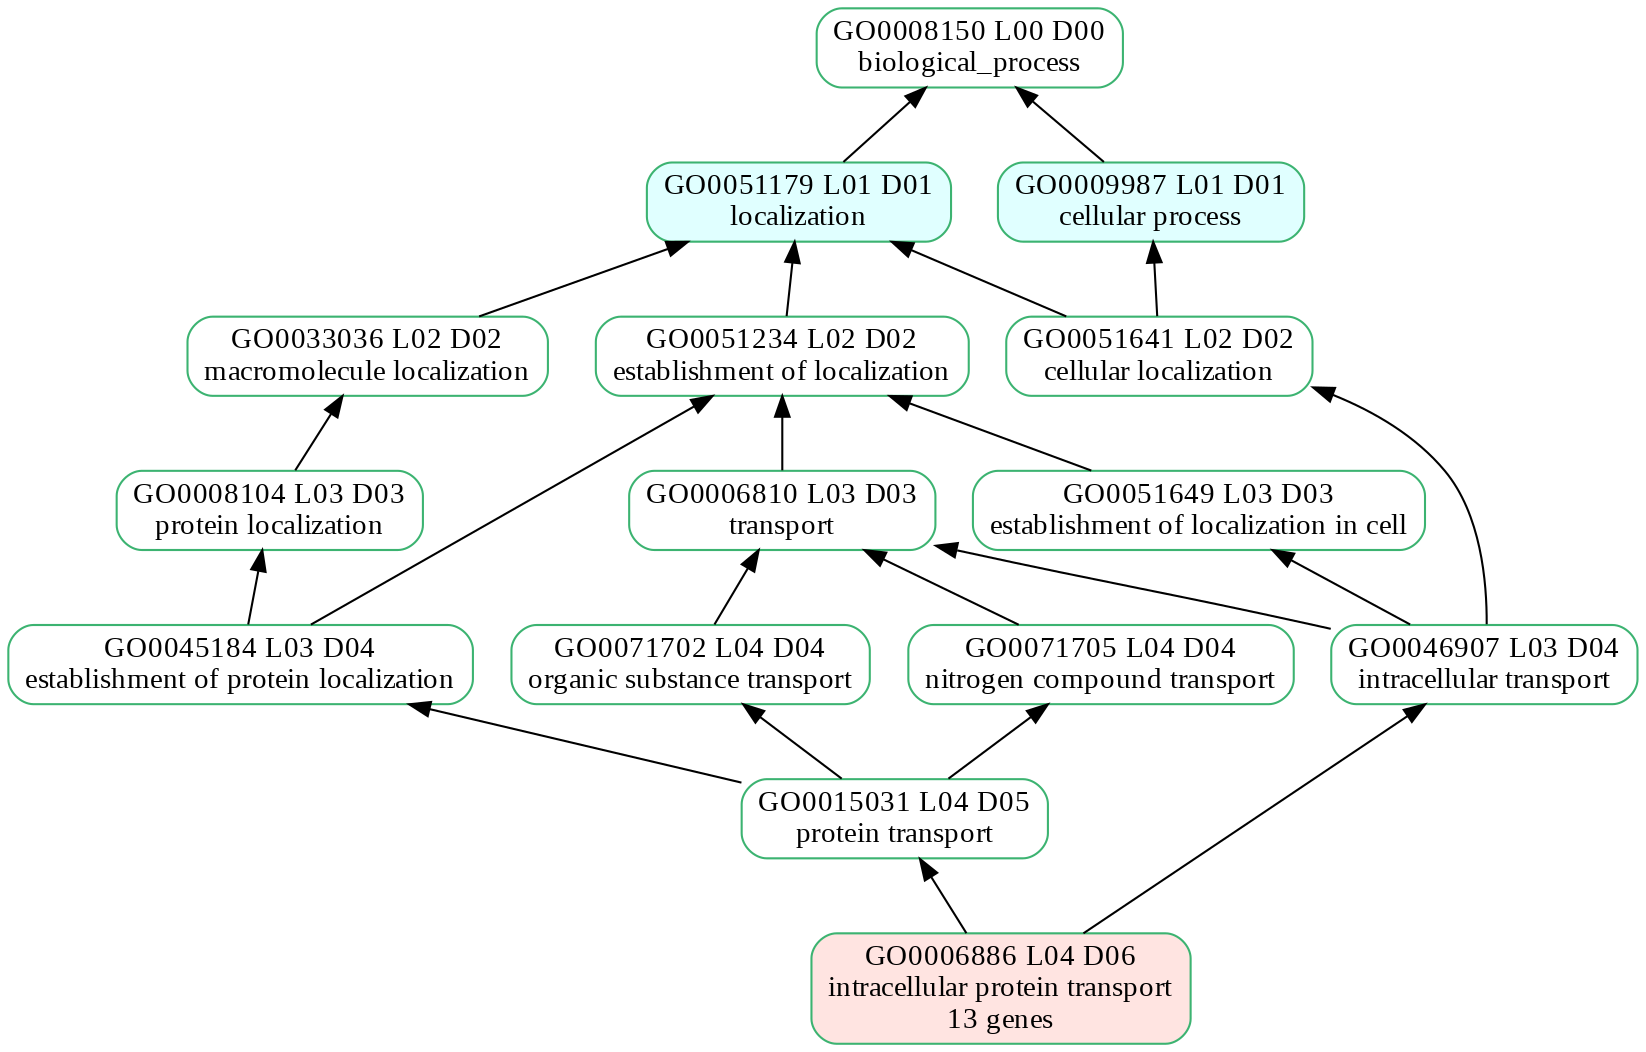

In [ ]:
Image(filename='fruit_unique_highly_expressed_genes_1_BP.png')

### GO enrichment for highly expressed genes in fruit TODO**

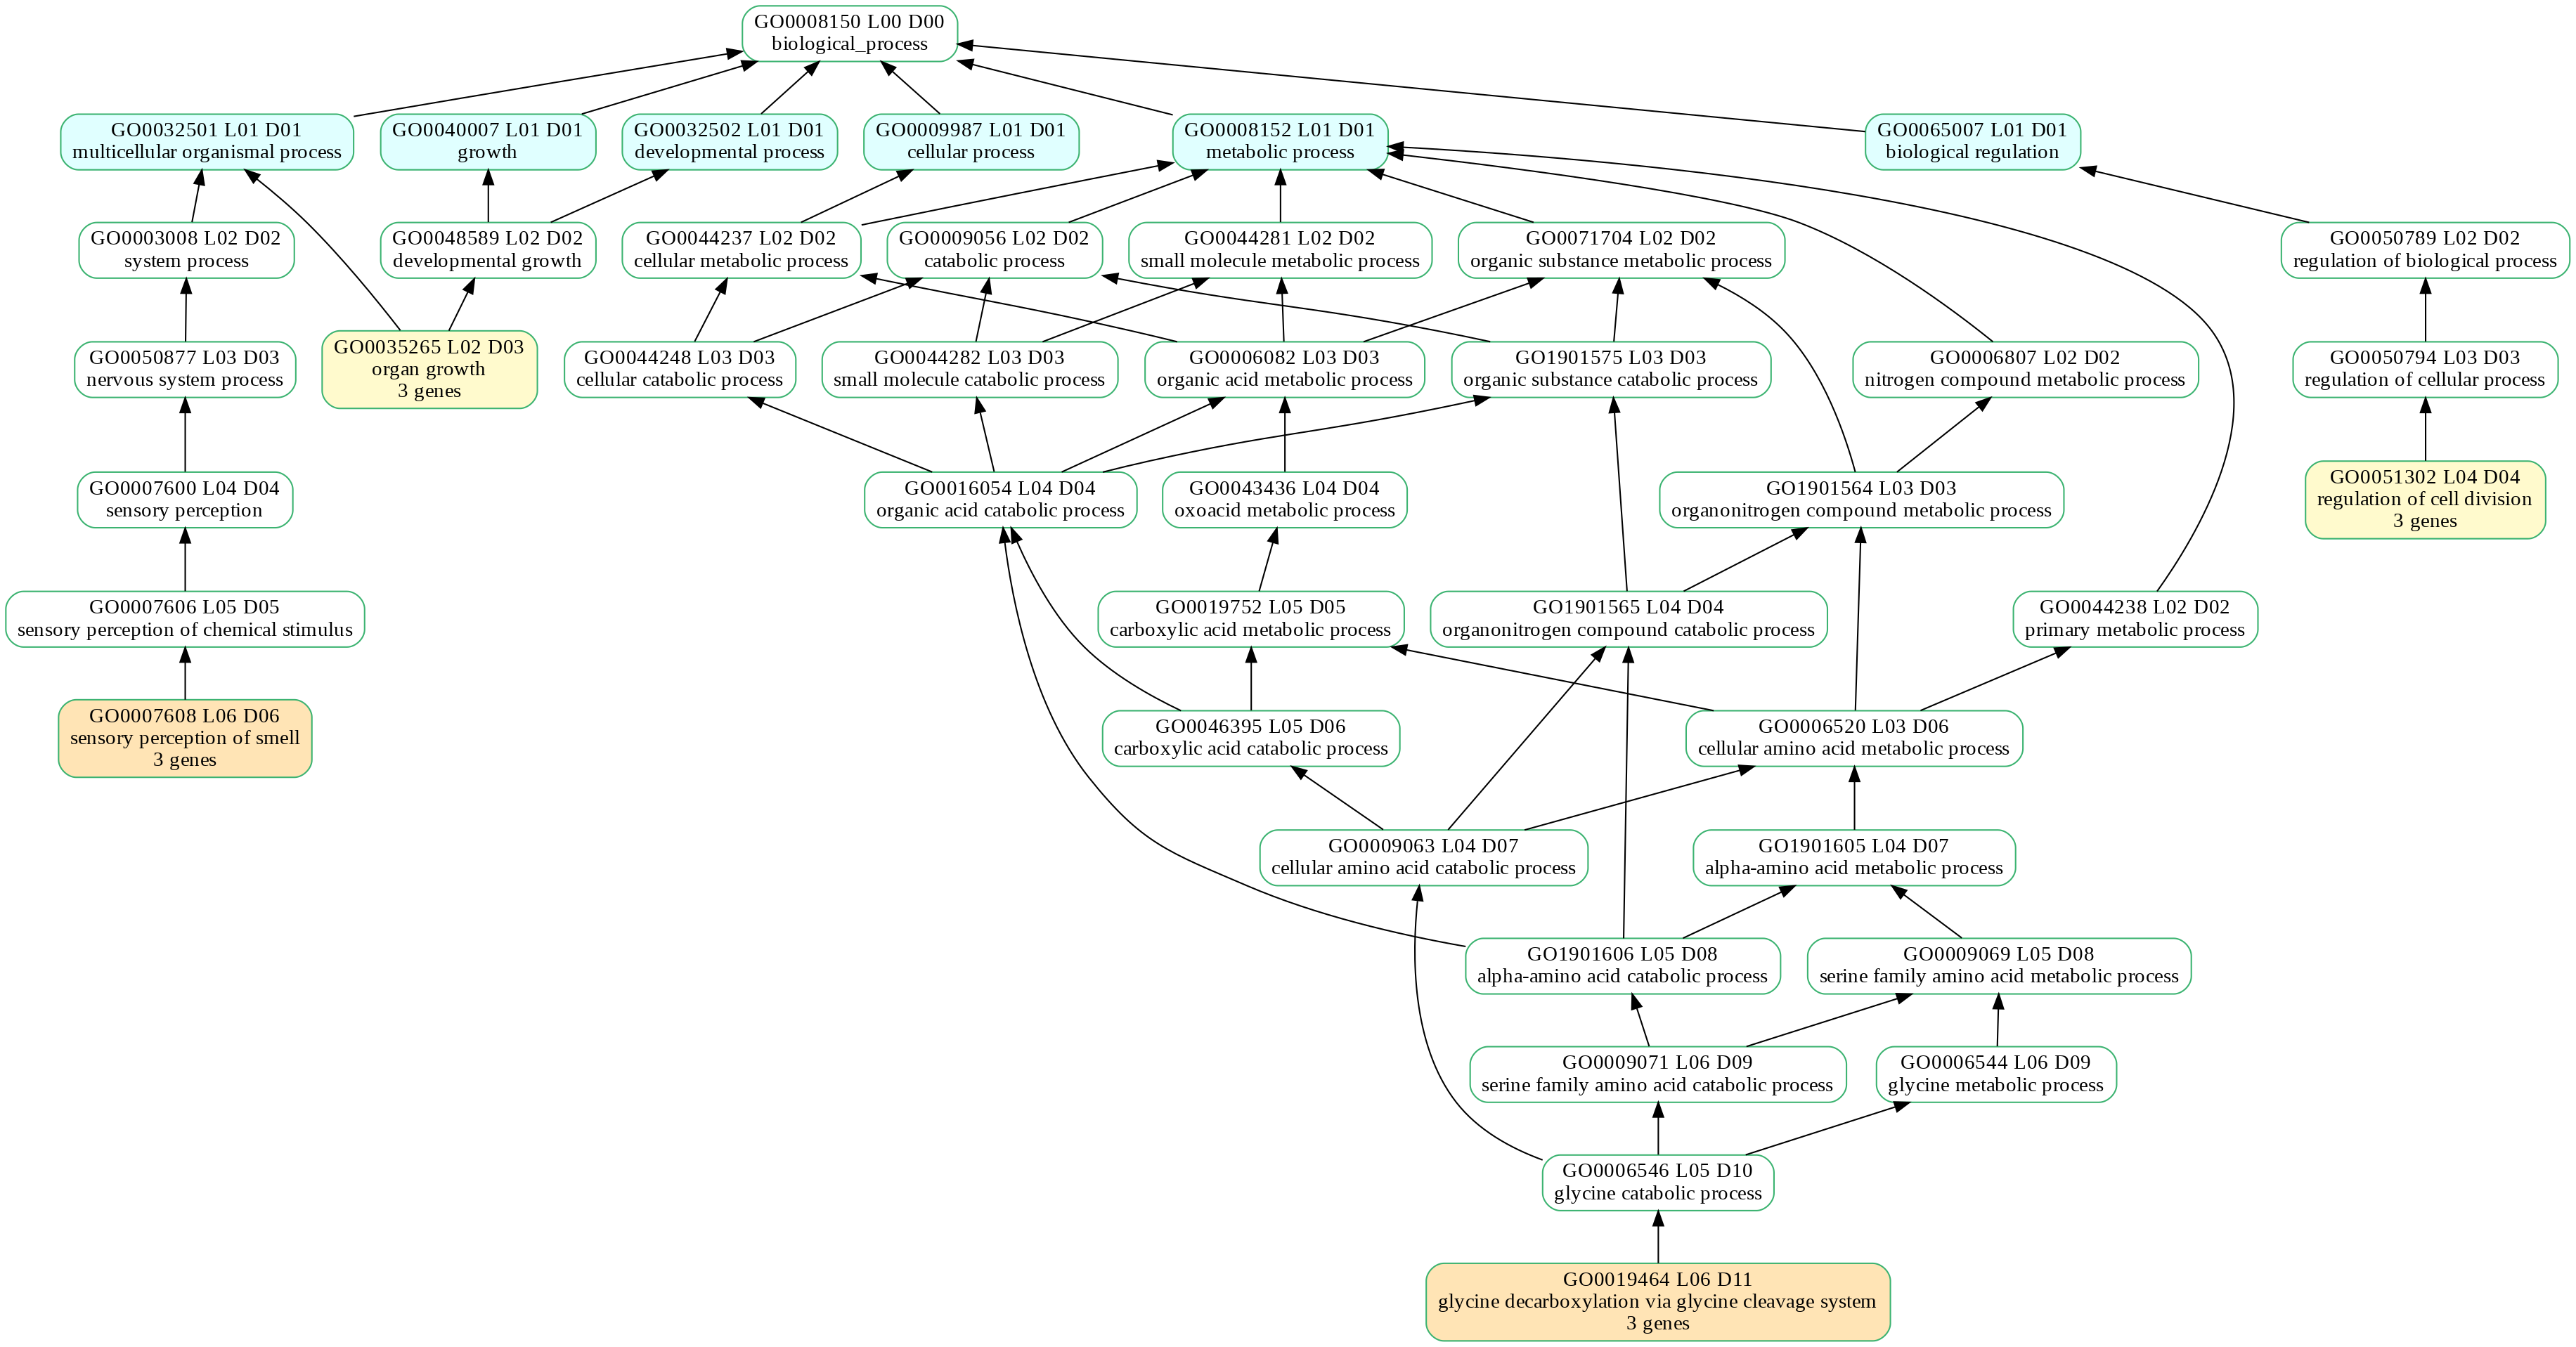

In [ ]:
Image(filename='fruit_highly_expressed_genes_3kb_BP.png')

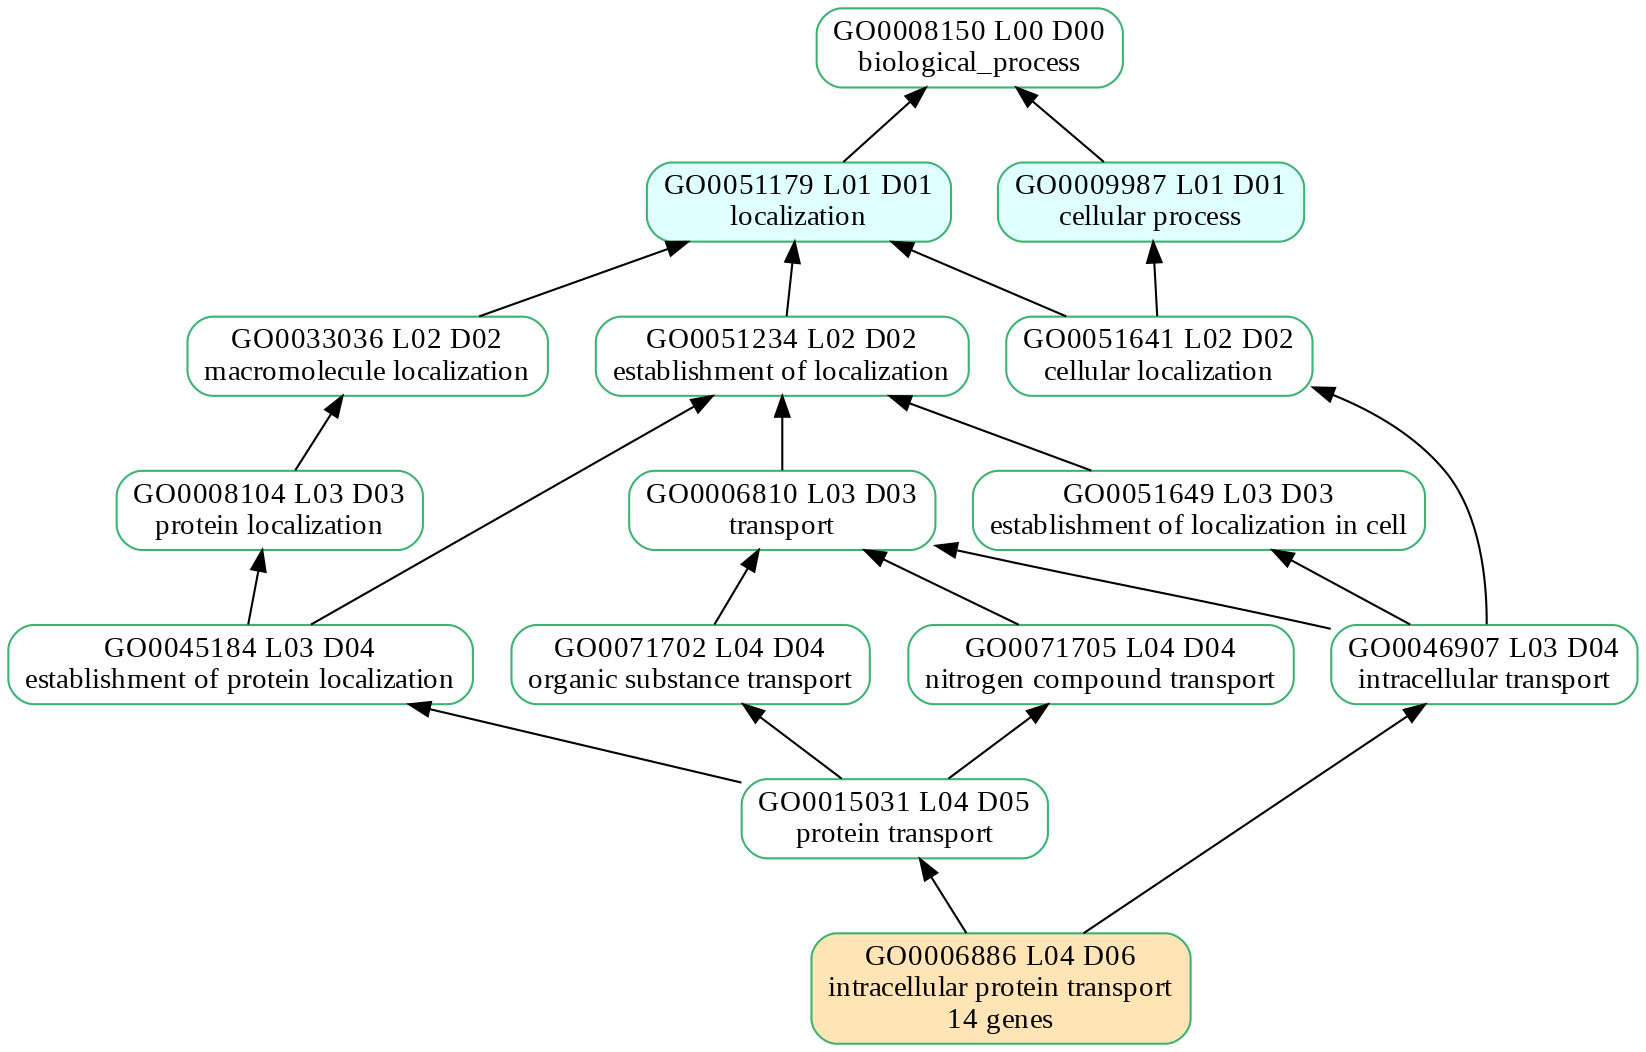

In [ ]:
Image(filename='fruit_highly_expressed_genes_2kb_BP.png')

### GO enrichment for highly expressed genes in stem TODO**

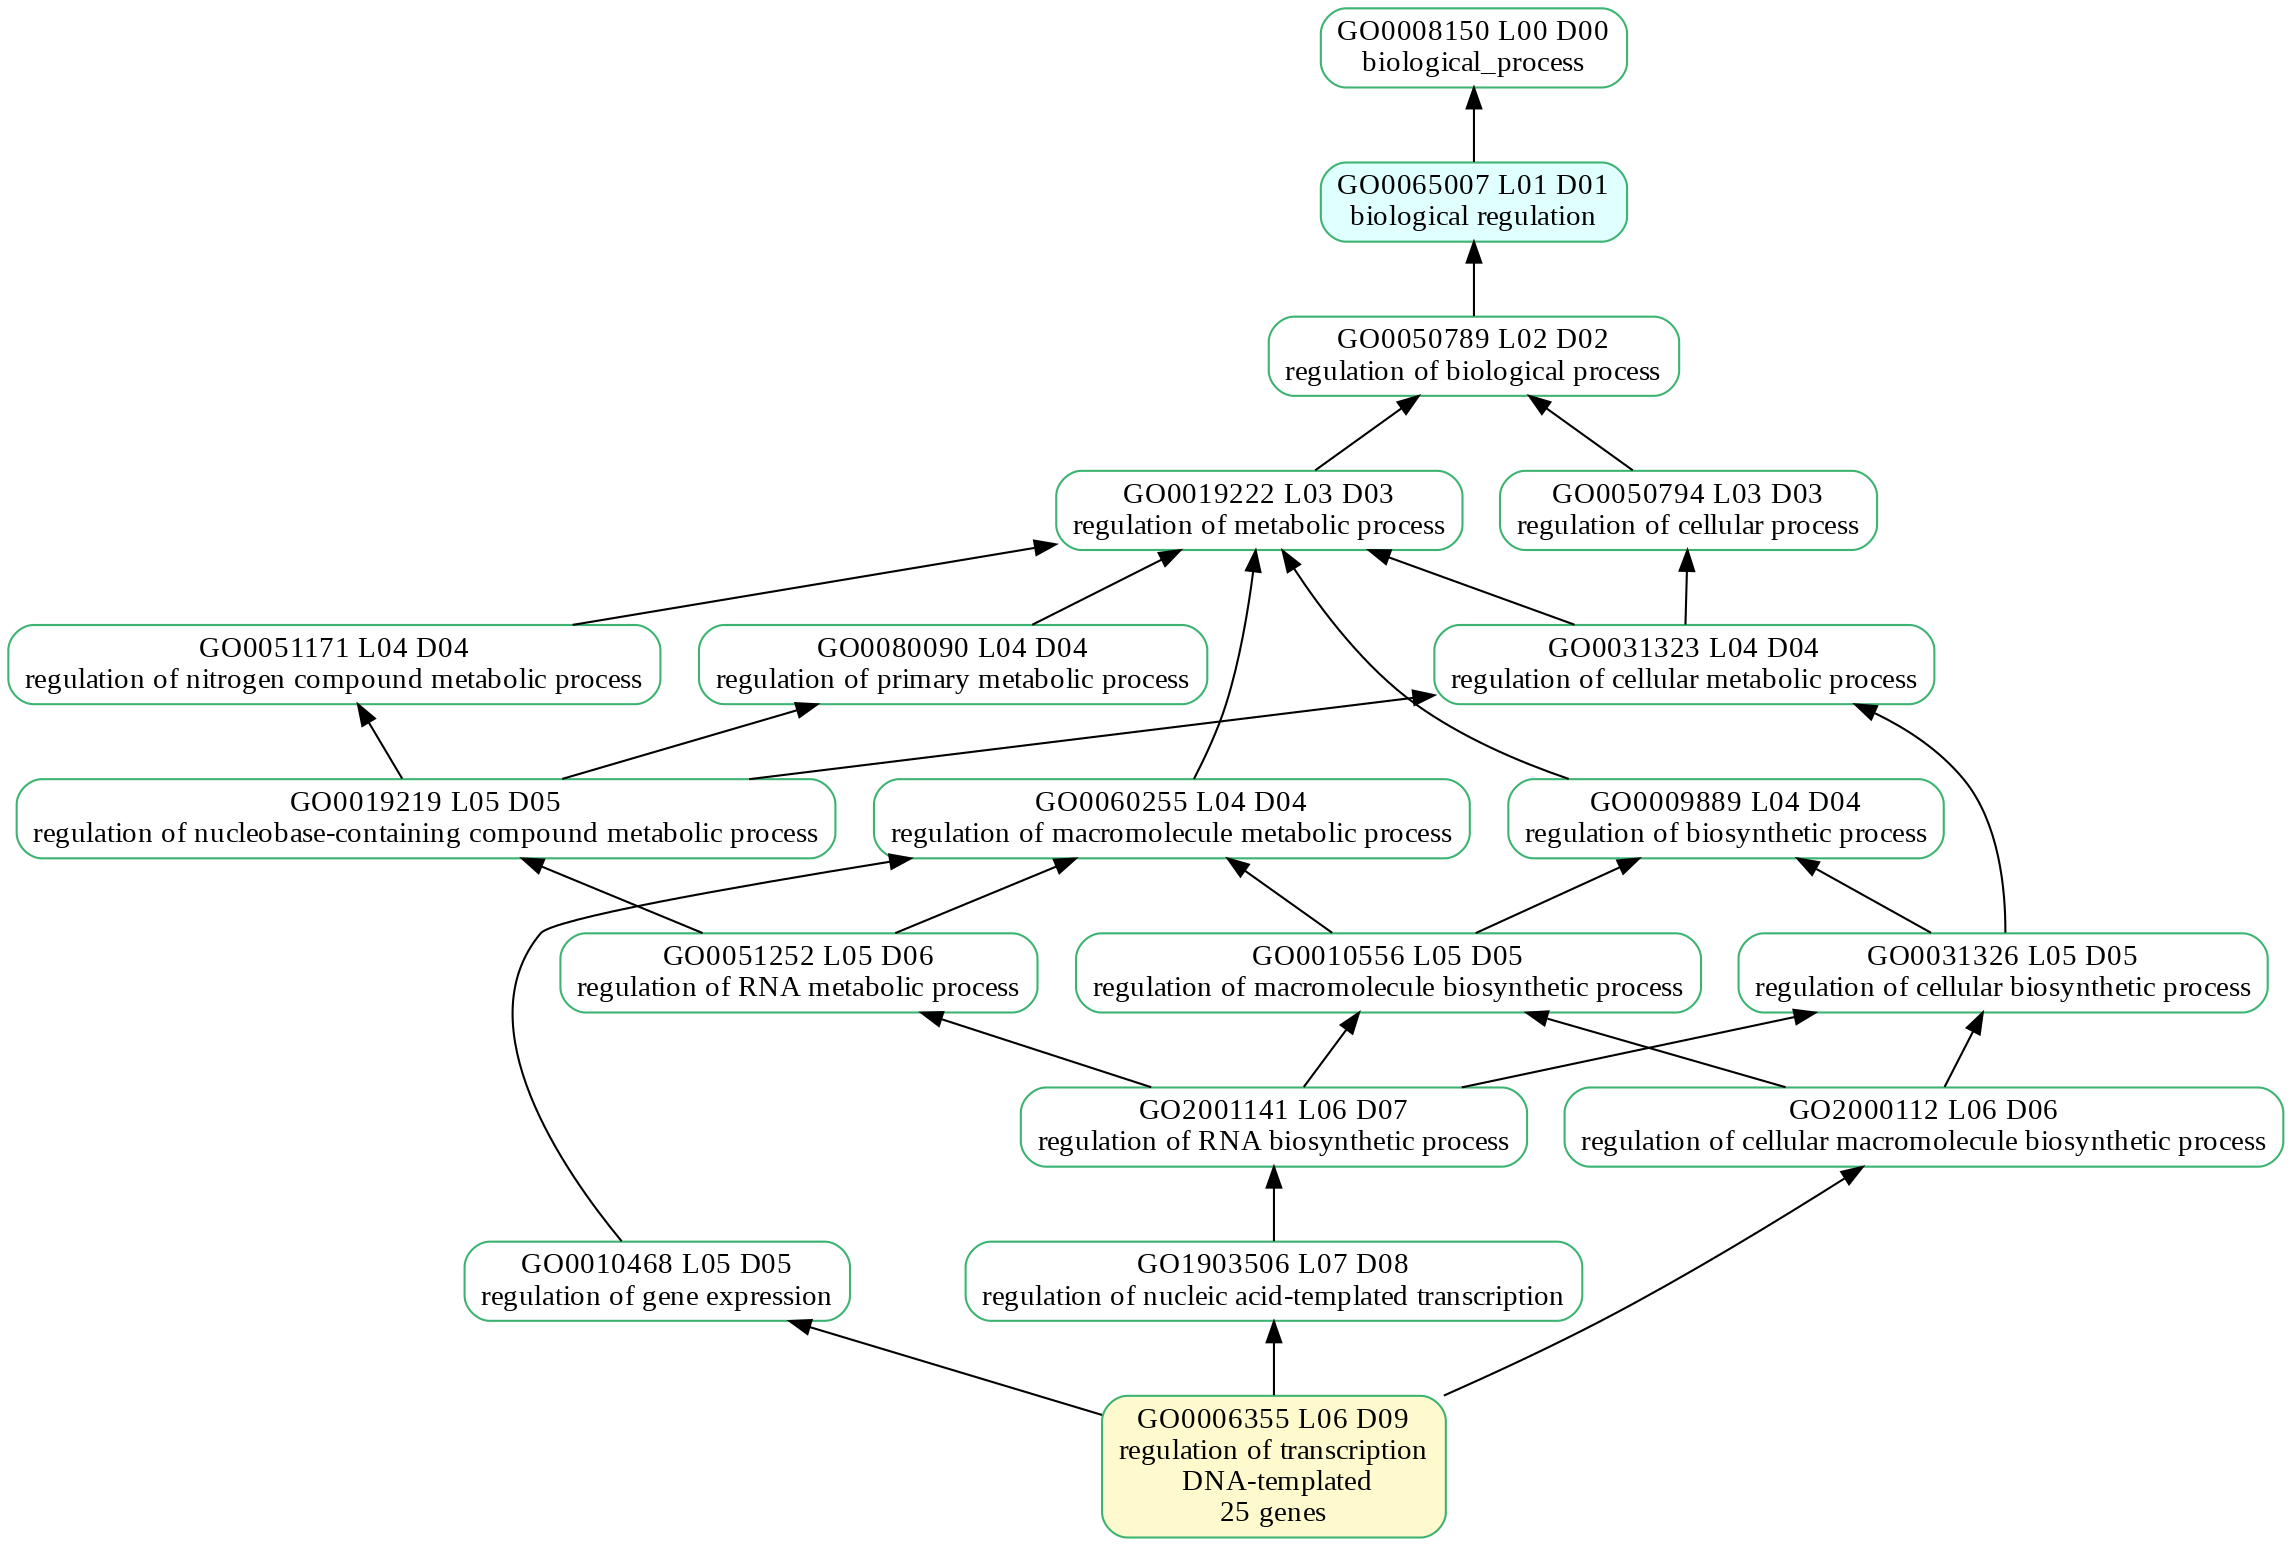

In [ ]:
Image(filename='stem_highly_expressed_genes_2kb_BP.png')

In [ ]:
for chunk in np.array_split(tissue_high_exp_genes['root'][0][1], 6):
  terms_sparql = [] 
  for gn in chunk:
      terms_sparql.append("{{?see_gramene <http://purl.uniprot.org/core/transcribedFrom> gramene:{gn}}}".format(gn=gn))

  sparql = SPARQLWrapper("https://sparql.uniprot.org/sparql")
  query = """
      PREFIX up: <http://purl.uniprot.org/core/>
      PREFIX taxon: <http://purl.uniprot.org/taxonomy/>
      PREFIX gramene: <http://purl.uniprot.org/gramene/>
      
      SELECT ?protein ?desc ?see_gramene
      WHERE
      {{
          ?protein a up:Protein .
          ?protein up:encodedBy ?gene .
          ?protein up:organism taxon:29760 . 
          ?protein <http://www.w3.org/2000/01/rdf-schema#seeAlso> ?see_gramene .
          ?protein <http://www.w3.org/2000/01/rdf-schema#label> ?desc .
          {genes}
      }}
  """.format(genes=' UNION '.join(terms_sparql))

  sparql.setQuery(query)
  sparql.setReturnFormat(JSON)
  results = sparql.query().convert()

  for result in results["results"]["bindings"]:
      print(result['see_gramene']['value'], result['desc']['value'])

http://purl.uniprot.org/gramene/VIT_18s0041g00900.t01 Uncharacterized protein
http://purl.uniprot.org/gramene/VIT_18s0122g00170.t01 Laccase
http://purl.uniprot.org/gramene/VIT_00s0225g00090.t01 Amine oxidase
http://purl.uniprot.org/gramene/VIT_00s0225g00090.t01 Uncharacterized protein
http://purl.uniprot.org/gramene/VIT_06s0080g01160.t01 Peptidase A1 domain-containing protein
http://purl.uniprot.org/gramene/VIT_03s0110g00030.t01 ANK_REP_REGION domain-containing protein
http://purl.uniprot.org/gramene/VIT_10s0003g01710.t01 UBD domain-containing protein
http://purl.uniprot.org/gramene/VIT_13s0067g03820.t01 Chalcone--flavanone isomerase 2
http://purl.uniprot.org/gramene/VIT_13s0067g03820.t01 Chalcone-flavonone isomerase family protein
http://purl.uniprot.org/gramene/VIT_01s0011g00280.t01 Protein kinase domain-containing protein
http://purl.uniprot.org/gramene/VIT_06s0004g04960.t01 GRAS domain-containing protein
http://purl.uniprot.org/gramene/VIT_11s0052g00450.t01 WRKY domain-containing p

In [ ]:
for chunk in np.array_split(tissue_high_exp_genes['fruit'][1][1], 10):
  terms_sparql = [] 
  for gn in chunk:
      terms_sparql.append("{{?see_gramene <http://purl.uniprot.org/core/transcribedFrom> gramene:{gn}}}".format(gn=gn))

  sparql = SPARQLWrapper("https://sparql.uniprot.org/sparql")
  query = """
      PREFIX up: <http://purl.uniprot.org/core/>
      PREFIX taxon: <http://purl.uniprot.org/taxonomy/>
      PREFIX gramene: <http://purl.uniprot.org/gramene/>
      
      SELECT ?protein ?desc ?see_gramene
      WHERE
      {{
          ?protein a up:Protein .
          ?protein up:encodedBy ?gene .
          ?protein up:organism taxon:29760 . 
          ?protein <http://www.w3.org/2000/01/rdf-schema#seeAlso> ?see_gramene .
          ?protein <http://www.w3.org/2000/01/rdf-schema#label> ?desc .
          {genes}
      }}
  """.format(genes=' UNION '.join(terms_sparql))

  sparql.setQuery(query)
  sparql.setReturnFormat(JSON)
  results = sparql.query().convert()

  for result in results["results"]["bindings"]:
      print(result['see_gramene']['value'], result['desc']['value'])

http://purl.uniprot.org/gramene/VIT_11s0016g00160.t01 Formin-like protein
http://purl.uniprot.org/gramene/VIT_05s0124g00520.t01 Uncharacterized protein
http://purl.uniprot.org/gramene/VIT_05s0077g00170.t01 Stress-response A/B barrel domain-containing protein
http://purl.uniprot.org/gramene/VIT_07s0129g00640.t01 Uncharacterized protein
http://purl.uniprot.org/gramene/VIT_09s0054g00610.t01 Uncharacterized protein
http://purl.uniprot.org/gramene/VIT_14s0083g00740.t01 Aa_trans domain-containing protein
http://purl.uniprot.org/gramene/VIT_12s0035g01740.t01 Dynamin GTPase
http://purl.uniprot.org/gramene/VIT_00s0577g00020.t01 Uncharacterized protein
http://purl.uniprot.org/gramene/VIT_14s0128g00100.t01 FAM86 domain-containing protein
http://purl.uniprot.org/gramene/VIT_06s0004g05970.t01 Uncharacterized protein
http://purl.uniprot.org/gramene/VIT_11s0052g00580.t01 Uncharacterized protein
http://purl.uniprot.org/gramene/VIT_17s0000g10010.t01 1,3-beta-glucan synthase
http://purl.uniprot.org/gram

### The following is the procedure to obtain p-values for all the query genes

In [ ]:
reverse_tissue_samples = {s.sampleName:k for k, v in tissue_samples.items() for s in v}

In [ ]:
multi_index = pd.MultiIndex.from_tuples([(reverse_tissue_samples.get(c, 'Other'), c) for c in module_rank.columns])

In [ ]:
module_rank.columns = multi_index

In [ ]:
def pvalue(tissue):
  def _pvalue(row):
    gene_ranks = row.values
    tissue_sample = row[tissue].dropna().index
    size = len(tissue_sample)
    gene_ranks_samples = np.random.choice(gene_ranks, size=(20000, size), replace=True)
    mean_dist = np.nanmean(gene_ranks_samples, axis=1)
    mean_sample = row[tissue][tissue_sample].mean()
    mu, sigma = stats.norm.fit(mean_dist[~np.isnan(mean_dist)])
    return stats.norm.sf(mean_sample, loc=mu, scale=sigma)
  return _pvalue

p_value_fruit = module_rank.loc[all_genes].apply(pvalue('fruit'), axis=1)
p_value_flower = module_rank.loc[all_genes].apply(pvalue('flower'), axis=1)
p_value_root = module_rank.loc[all_genes].apply(pvalue('root'), axis=1)
p_value_leaf = module_rank.loc[all_genes].apply(pvalue('leaf'), axis=1)
p_value_stem = module_rank.loc[all_genes].apply(pvalue('stem'), axis=1)

p_values = pd.DataFrame([p_value_fruit, p_value_flower, p_value_root, p_value_leaf, p_value_stem], index=['fruit', 'flower', 'root', 'leaf', 'stem'])
p_values.to_csv('p_values.csv', sep='\t')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:291: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning:

Mean of empty slice.



### How to obtain the complete TPM module

In [ ]:
all_bf = BiologicalFeature.using(compendium_tpm).get()

In [ ]:
all_samplesets = SampleSet.using(compendium_tpm).get()

In [ ]:
tpm_module_1 = Module.using(compendium_tpm).create(biofeatures=all_bf, samplesets=all_samplesets[:1000])

In [ ]:
tpm_module_2 = Module.using(compendium_tpm).create(biofeatures=all_bf, samplesets=all_samplesets[1000:2000])

In [ ]:
tpm_module_3 = Module.using(compendium_tpm).create(biofeatures=all_bf, samplesets=all_samplesets[2000:3000])

In [ ]:
tpm_module_4 = Module.using(compendium_tpm).create(biofeatures=all_bf, samplesets=all_samplesets[3000:])

In [ ]:
module_1_df = pd.DataFrame(tpm_module_1.values, columns=[ss.name for ss in tpm_module_1.sample_sets], index=[bf.name for bf in tpm_module_1.biological_features])
module_2_df = pd.DataFrame(tpm_module_2.values, columns=[ss.name for ss in tpm_module_2.sample_sets], index=[bf.name for bf in tpm_module_2.biological_features])
module_3_df = pd.DataFrame(tpm_module_3.values, columns=[ss.name for ss in tpm_module_3.sample_sets], index=[bf.name for bf in tpm_module_3.biological_features])
module_4_df = pd.DataFrame(tpm_module_4.values, columns=[ss.name for ss in tpm_module_4.sample_sets], index=[bf.name for bf in tpm_module_4.biological_features])


In [ ]:
module_tmp = pd.concat([module_1_df, module_2_df, module_3_df, module_4_df], axis=1)

In [ ]:
module_tmp.to_hdf('vespucci_tpm.hdf', 'table')